In [1]:
import scanpy as scanpy
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation
import pandas as pd
import SEACells

In [2]:
adata = sc.read_h5ad('/data_nfs/og86asub/datasets/cellxgene/blood_sc/raw/73d4409b-8464-49f3-a4d6-c18ac41fafbb.h5ad')


In [3]:
adata.obs['cell_type']

index
CCGGGATAGTCCTCCT-SG_B1_L1     CD16-positive, CD56-dim natural killer cell, h...
CCGGTAGCACAGACTT-SG_B1_L1     CD16-positive, CD56-dim natural killer cell, h...
TAGCCGGGTCACCTAA-SG_B1_L1                                CD14-positive monocyte
CAGCGACTCCACTCCA-SG_B1_L1                                CD14-positive monocyte
CACAGTAGTGTCCTCT-SG_B1_L1                CD8-positive, alpha-beta memory T cell
                                                    ...                        
GACTGCGCACTTAAGC-KR_B12_L2                                        memory B cell
GTTACAGCACACTGCG-KR_B12_L2                     CD14-low, CD16-positive monocyte
ACACTGAAGTGTTGAA-KR_B12_L2                               CD14-positive monocyte
GATCGTACATCGACGC-KR_B12_L2                               CD14-positive monocyte
TTCTTAGAGCTAGGCA-KR_B12_L2                                   gamma-delta T cell
Name: cell_type, Length: 1058909, dtype: category
Categories (33, object): ['T cell', 'erythrocyte', 'platelet', '

In [8]:
adata = adata[adata.obs['cell_type'] == 'B cell', :]

In [9]:
biomart = pd.read_csv('/data_nfs/og86asub/scFL-Green/raw/biomart.txt', sep = '\t')
biomart = biomart.loc[:,["Gene stable ID", 'Gene name']]
biomart = biomart.drop_duplicates()


In [10]:
adata.var = adata.var.reset_index()
adata.var = adata.var.merge(biomart, left_on='index', right_on='Gene stable ID', how='left')


In [11]:

adata.var['keep'] = ~pd.isna(adata.var['Gene name'])
adata = adata[:, adata.var.keep]

In [14]:
adata.var["mt"] = adata.var['Gene name'].str.startswith(("MT-"))
adata.var["mt"] = adata.var['Gene name'].str.startswith(("MT-"))

# ribosomal genes
adata.var["ribo"] = adata.var['Gene name'].str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var['Gene name'].str.contains("^HB[^(P)]")

In [13]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

adata.obs["mt_outlier"] = (adata.obs["pct_counts_mt"] > 10)

adata = adata[ (~adata.obs.mt_outlier)].copy()
sc.pp.filter_genes(adata, min_cells=20)
sc.pp.filter_cells(adata, min_genes=200)

/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)


ValueError: cannot convert float NaN to integer

In [73]:
adata

AnnData object with n_obs × n_vars = 10204 × 19931
    obs: 'donor_id', 'tissue_in_publication', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'assay_ontology_term_id', 'sample_id', 'replicate', '10X_run', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_type_ontology_term_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'ethnicity_original', 'scvi_leiden_res05_tissue', 'sample_number', 'suspension_type', 'tissue_type', 'disease_ontology_term_id', 'is_primary_data', 'tissue_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'developm

In [74]:
scales_counts = sc.pp.normalize_total(adata, target_sum=10000, inplace=False)
# log1p transform


In [75]:
adata.layers['counts'] = scales_counts["X"]

In [76]:
adata.layers['counts']

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 29419337 stored elements and shape (10204, 19931)>

In [77]:
adata.layers["log1p"] = sc.pp.log1p(adata.layers['counts'], copy=True)
sc.pp.highly_variable_genes(adata, layer="log1p", n_top_genes=4000)


sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True, layer='log1p')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


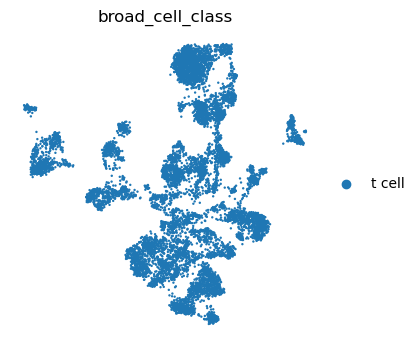

In [78]:
sc.pl.umap(
    adata,
    color=['broad_cell_class'],
    frameon=False,
    sort_order=False
)

In [79]:
n_SEACells = int(np.floor(adata.shape[0]/75))
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10


model = SEACells.core.SEACells(adata, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

model.construct_kernel_matrix()
M = model.kernel_matrix

model.initialize_archetypes()
model.fit(min_iter=10, max_iter=50)

Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/10204 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/10204 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/10204 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 130 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 16/16 [00:00<00:00, 158.43it/s]

Selecting 6 cells from greedy initialization.
Randomly initialized A matrix.


Setting convergence threshold at 0.00186
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Converged after 18 iterations.


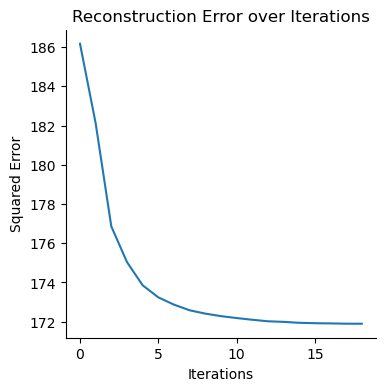

In [80]:
model.plot_convergence()

In [81]:
SEACell_ad = SEACells.core.summarize_by_SEACell(adata, SEACells_label='SEACell', summarize_layer='X')



  0%|          | 0/136 [00:00<?, ?it/s]

100%|██████████| 136/136 [00:01<00:00, 83.43it/s]
/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/SEACells/plot.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mcs = umap.groupby("SEACell").mean().reset_index()
/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


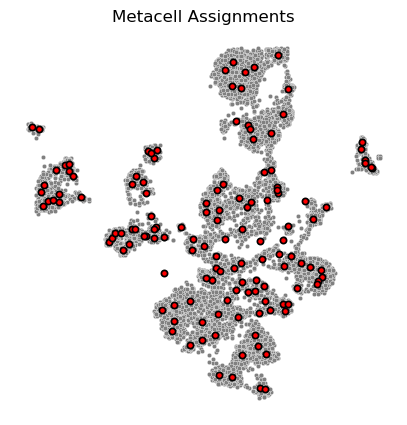

In [82]:
SEACells.plot.plot_2D(adata, key='X_umap', colour_metacells=False)

/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/SEACells/plot.py:130: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby("SEACell").count().iloc[:, 0], bins=bins)


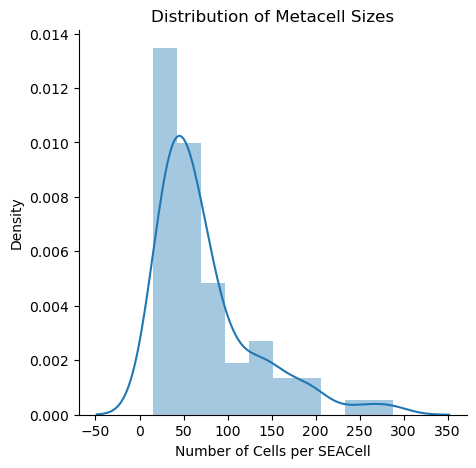

,size
SEACell,
SEACell-0,135
SEACell-1,42
SEACell-10,47
SEACell-100,63
SEACell-101,31
...,...
SEACell-95,107
SEACell-96,38
SEACell-97,127


In [83]:
SEACells.plot.plot_SEACell_sizes(adata, bins=10)

In [85]:
SEACell_ad.shape

(136, 19931)

In [ ]:
## Order genes 
## Harmonize genes
adata.write('/data_nfs/og86asub/datasets/cellxgene/blood_sc/me')


In [ ]:
#adata.layers['log1p']

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 207910 stored elements and shape (100, 26680)>